# A quick mini-batch example using numpy
Another great example of out of core processing using generators (By Sebastian Raschka, of course), can be found here:
- https://github.com/rasbt/pattern_classification/blob/master/machine_learning/scikit-learn/outofcore_modelpersistence.ipynb

In this example, we explicitly use numpy memory maps instead of writing our own generators. The end result is approximately the same, though. 

In [1]:
# lets first setup some memory mapped file

# more data for handwriting recognition?
import os
import numpy as np
# from sklearn.preprocessing import RobustScaler
 
def load_mnist(path, kind='train'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path, '%s-labels.mmap' % kind)
    images_path = os.path.join(path, '%s-images.mmap' % kind)
    
    labels = np.memmap(labels_path, offset=8, dtype=np.uint8, mode='r')
    images = np.memmap(images_path, offset=16, shape=(len(labels), 784), dtype=np.uint8, mode='r')
 
    return images, labels

X_train, y_train = load_mnist('data/', kind='train')
print('Rows: %d, columns: %d' % (X_train.shape[0], X_train.shape[1]))

X_test, y_test = load_mnist('data/', kind='t10k')
print('Rows: %d, columns: %d' % (X_test.shape[0], X_test.shape[1]))



Rows: 60000, columns: 784
Rows: 10000, columns: 784


In [2]:
X_train

memmap([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

255


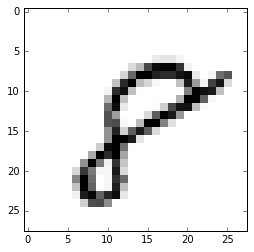

In [3]:
# now we can access different portions of the data
# without loading the whole thing into RAM
import matplotlib.pyplot as plt
%matplotlib inline

img = X_train[-1].reshape(28, 28) # only a small portion is loaded into working memory
plt.imshow(img, cmap='Greys', interpolation='nearest')
print(np.max(img))

plt.show()

In [4]:
%%time 
# If we try to perform an operation on the entirety
#  of X_train, it will load the entire array
#  but we can manually load rows in chunks

from sklearn.linear_model import SGDClassifier, Perceptron
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
# different classifiers that incorporate partial fit
# clf = Perceptron(random_state=1)
# clf = MultinomialNB()
# clf = MLPClassifier(hidden_layer_sizes=(50, ), 
#                     activation='relu', 
#                     solver='sgd', 
#                     alpha=1e-4, # L2 penalty
#                    )
clf = SGDClassifier(loss='log', n_iter=10)

classes = np.arange(0,10) # partial fit needs to know all the classes
idx = 0     # starting index
size= 1000  # mini batch size
for _ in range(1000):
    # load partially from file
    X_train_mini = X_train[idx:idx+size] 
    y_train_mini = y_train[idx:idx+size]
    # note: must be continuous slicing to avoid loading entire matrix
    
    # fit with minibatch
    clf.partial_fit(X_train_mini/255.0, y_train_mini, classes=classes)
    
    # adjust where to read from for minibatch
    idx = idx+size if idx+size<len(y_train) else len(y_train)-idx

CPU times: user 28.3 s, sys: 1.74 s, total: 30 s
Wall time: 31 s


In [5]:
from sklearn.metrics import accuracy_score
yhat = clf.predict(X_test/255.0)

print(accuracy_score(yhat,y_test))

0.914
